<a href="https://colab.research.google.com/github/Vaniotosta/Projeto-Data-Science/blob/main/MODELO_DE_PREVISAO_PASSAGENS_AEREAS_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PREVISÃO DE TARIFAS PARA PASSAGENS AÉREAS**

![](https://super.abril.com.br/wp-content/uploads/2017/08/como-o-aquecimento-global-estc3a1-atrapalhando-a-aviac3a7c3a3o-civil.png)

#PROBLEMA DE NEGÓCIO


Um dos  grandes desafios dentro do mundo dos negócios das companhias aéreas ou afins, é prever uma estimativa de preços justo que seja adequado ao perfil dos clientes e das empresas portadoras desses serviços. Nesse contexto, se faz importante as análises dos dados para que se possa compreender o comportamento desse clientes no intuito de gerar valor competitivo através das técnicas de aprendizado de máquinas. Sendo assim esse projeto tem como onjetivo:

**- Fazer uma estimativa de preços para passagens aéreas com base nos históricos dos passageiros** 

## Conjunto dos dados

Companhia Aérea: Esta coluna terá todos os tipos de companhias aéreas como Indigo, Jet Airways, Air India e muitas outras.

Date_of_Journey: Esta coluna nos informará sobre a data em que a viagem do passageiro começará.

Fonte: Esta coluna contém o nome do local de onde começará a viagem do passageiro.

Destino: Esta coluna contém o nome do local para onde os passageiros queriam viajar.

Rota: Aqui podemos saber qual é a rota pela qual os passageiros optaram por viajar desde a sua origem até ao seu destino.

Arrival_Time: A hora de chegada é quando o passageiro chegará ao seu destino.

Duração: Duração é todo o período de tempo que um voo levará para completar sua jornada da origem ao destino.

Total_Stops: Isso nos informará em quantos lugares os voos vão parar lá para o voo em toda a viagem.

Additional_Info: Nesta coluna, obteremos informações sobre comida, tipo de comida e outras comodidades.

Preço: Preço do voo(referência Índia) para uma viagem completa incluindo todas as despesas antes do embarque.

In [1]:
# Importação de pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# Métricas

from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error
from sklearn.metrics import r2_score,mean_absolute_error
from math import sqrt
# modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Vakidação
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [2]:
# ignorar mensagens
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Conexão com os dados de treino

train_df = pd.read_excel("Data_Train.xlsx")
train_df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662


In [4]:
# Conexão com os dados de teste
test_df = pd.read_excel("/content/Test_set.xlsx")
test_df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info


- OBSERVANDO OS DADOS DE TREINO

In [5]:
train_df.columns


Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

Muitas variávies objetos e poucos nulos, requer tratamentos! 

In [6]:
# byscando informação treino
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
# Verifica valores Missing
train_df.isnull().sum()


Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Como tinha apenas 2 dados nulos , foi escolhido eliminá-los

In [8]:
# excluindo dados nulos dos treino
train_df.dropna(inplace= True)

In [9]:
train_df.describe()

,Price
count,10682.000000
mean,9087.214567
std,4611.548810
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


- O describe demonstra que os preços variam entre 1759 e 79512, sendo que 50% desses valores concentra-se até 8372, isso significa que pode existir serviços diferenciados e/ou clientes que expliquem esses outikiers.

In [10]:
# Verifica valores  Duplicados
train_df[train_df.duplicated()].head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303


In [11]:
# Elimina valor duplicado mantendo o 1° registro.
train_df.drop_duplicates(keep='first',inplace=True)

- OBSERVANDO OS DADOS DE TESTE

In [12]:
# dados de treino sem nulo
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [13]:
test_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [14]:
test_df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')

In [15]:
# verificando dados duplicados dos treinos
test_df[test_df.duplicated()].head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
294,Jet Airways,12/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 13 Jun,22h 55m,2 stops,No info
794,Jet Airways,12/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 13 Jun,22h 55m,2 stops,In-flight meal not included
909,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,20:00,22:55,2h 55m,non-stop,No info
974,Air India,12/06/2019,Kolkata,Banglore,CCU → DEL → AMD → BLR,07:00,05:25 13 Jun,22h 25m,2 stops,No info
1011,Jet Airways,9/05/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 10 May,22h 55m,2 stops,No info


In [16]:
# Elimina valor duplicado mantendo o 1° registro dos treino.
test_df.drop_duplicates(keep='first',inplace=True)

## EDA - ANÁLISE EXPLORATÓRIA DOS DADOS DE TREINO

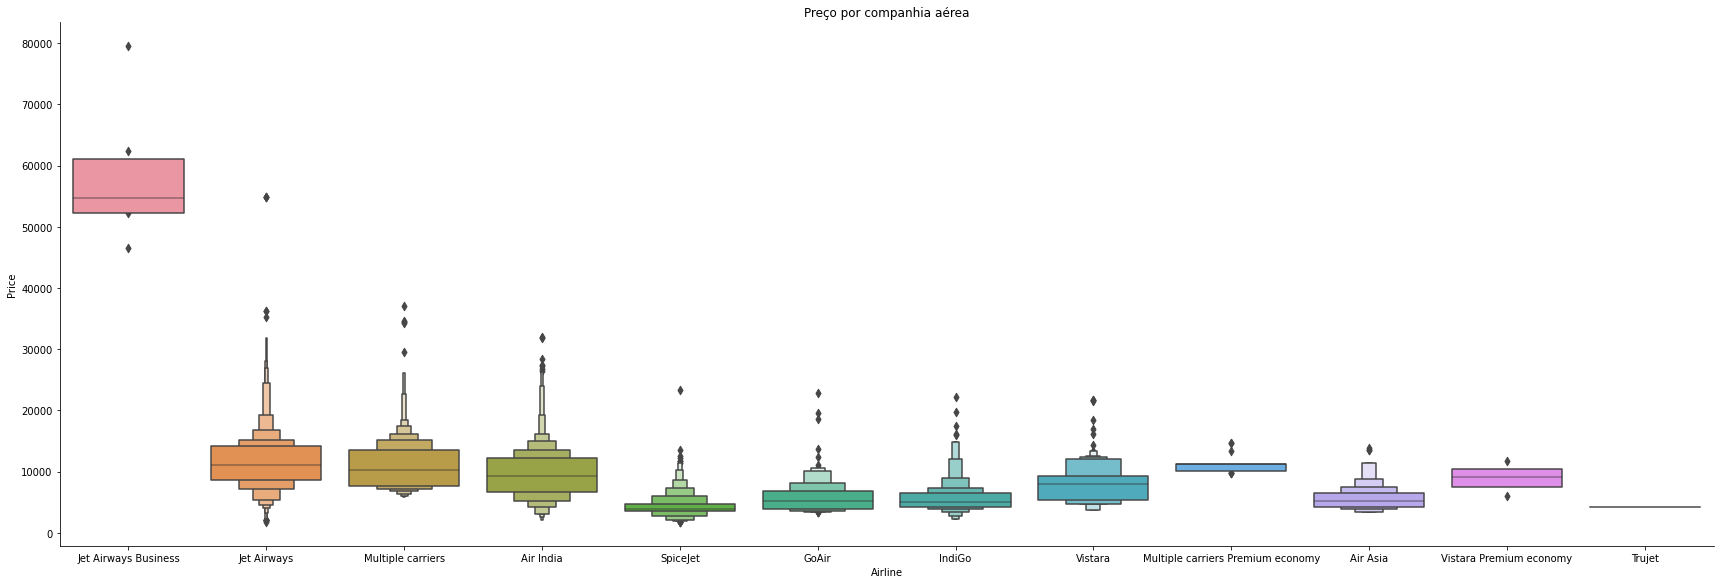

In [17]:
# Plotando box para Preço vs Airline (companhia)
sns.catplot(y = "Price", x = "Airline", data = train_df.sort_values("Price", ascending = False), kind="boxen", height = 8, aspect = 3)
plt.title('Preço por companhia aérea')
plt.show()

- Observando os preços em relação as companhias aéreas percebe-se que a companhia JET ARWAYS BUSINESS se destaca das maiorias, talvez esse destaque nos preços evidencie um serviço ou produtos diferenciados no que tange ao público alvo.

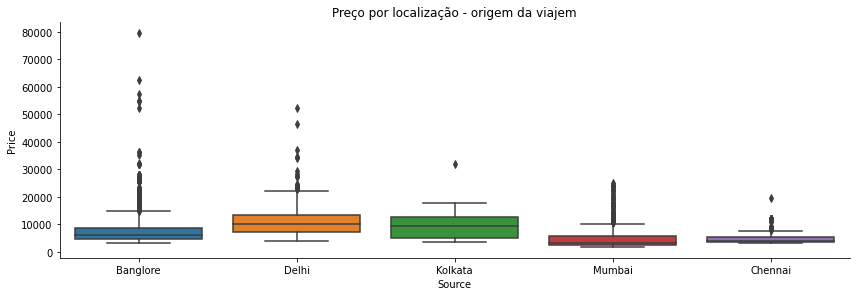

In [18]:
# Plotando Violin plot preço vs Source (inicio da viagem)
sns.catplot(y = "Price", x = "Source", data = train_df.sort_values("Price", ascending = False), kind="box", height = 4, aspect = 3)
plt.title('Preço por localização - origem da viajem')
plt.show()

- Em relação preços e localização do inicio das viagens, percebe-se que os valores se emcontram  nos custos de 10000 e 20000. Porém KOLKATA e DELHI apresentam uma leve supremacia em relação às outras. além disso, esse gráfico apresenta os cincos principais voos de origens

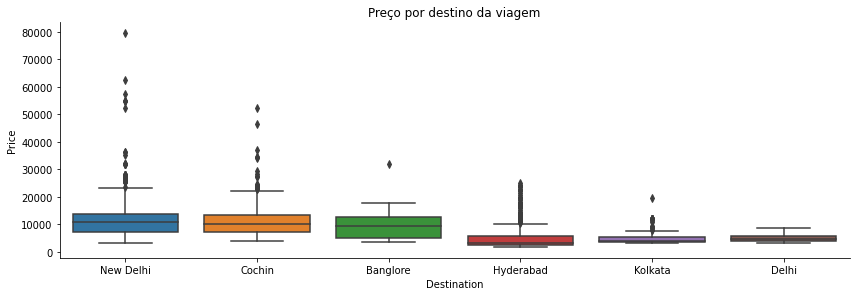



Preços por destino


Destination  Price
Cochin       10262    258
Banglore     10844    212
             4804     160
Delhi        7229     154
             4823     131
                     ... 
Cochin       9732       1
             9706       1
             9601       1
             9595       1
New Delhi    79512      1
Name: Price, Length: 1962, dtype: int64

In [19]:
# Plotando  Box plot preços e destino
sns.catplot(y = "Price", x = "Destination", data = train_df.sort_values("Price", ascending = False), kind="box", height = 4, aspect = 3)
plt.title('Preço por destino da viagem')
plt.show()

print('\n')
print('Preços por destino')

train_df.groupby("Destination" )["Price"].value_counts().sort_values(ascending=False)


- Quanto ao preço por destino se destaca COCHIN  e  BANGLORE com os melhores preços destinos. è importante ressaltar que os voos de destino se diferenciam em preços e localização aos de origens.

In [20]:
# Contando das viagens em relação ao duração e ao preços
train_df.groupby('Duration')["Price"].value_counts(ascending=False
                                                   )


Duration  Price
10h       14714    7
          8099     5
          10197    5
          10262    4
          14237    4
                  ..
9h 5m     7905     1
          8018     1
          9736     1
          10493    1
          10696    1
Name: Price, Length: 4938, dtype: int64

- O maior número de viagens em relação ao preço está com duração de 10hs e valor de 14714. porém existem preços menores com a mesma duraçao de viagens, levando a considerar que a duração do tempo de voo, não determina por si só as tarifas.

## PRÉ-PROCESSAMENTO

In [21]:
# Observando as primeiras linhas
train_df.head(4)



,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218


In [22]:
# Convertendo a variável Duration em horas e minutos (dados de treino e teste)
train_df['Duration']=train_df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
test_df['Duration'] = test_df['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [23]:
train_df.head(4)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218


- Aqui foi necessário  pegar a coluna data e transformar em colunas dia e mês em separado.

In [24]:
# Date_of_Journey ( transformando colunas)
train_df["Journey_day"] = train_df['Date_of_Journey'].str.split('/').str[0].astype(int)
train_df["Journey_month"] = train_df['Date_of_Journey'].str.split('/').str[1].astype(int)
train_df.drop(["Date_of_Journey"], axis = 1, inplace = True) # dropando coluna date antiga
train_df.head(4)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1 stop,No info,6218,12,5


- Aqui foi criada uma coluna para hora e outra para minutos e dropada a antiga coluna.

In [25]:
# transformando a coluna tempo (dep_time)
train_df["Dep_hour"] = pd.to_datetime(train_df["Dep_Time"]).dt.hour
train_df["Dep_min"] = pd.to_datetime(train_df["Dep_Time"]).dt.minute
train_df.drop(["Dep_Time"], axis = 1, inplace = True) # dropando a coluna antiga
train_df.head(2)

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,170,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,445,2 stops,No info,7662,1,5,5,50


- Aqui foi criada a coluna arrival_hour e arrival_min, separando em horas e minutos, depois excluindo a antiga coluna.

In [26]:
# Arrival_Time (criando colunas de horas e minutos)
train_df["Arrival_hour"] = pd.to_datetime(train_df.Arrival_Time).dt.hour
train_df["Arrival_min"] = pd.to_datetime(train_df.Arrival_Time).dt.minute
train_df.drop(["Arrival_Time"], axis = 1, inplace = True)
train_df.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,1,5,5,50,13,15


### **OBS: TODOS OS PROCESSAMENTOS DEVEM SER REPETIDO NOS DADOS DE TESTE (VALIDAÇÃO).**

In [27]:
# Date_of_Journey ( transformando colunas)
test_df["Journey_day"] = test_df['Date_of_Journey'].str.split('/').str[0].astype(int)
test_df["Journey_month"] = test_df['Date_of_Journey'].str.split('/').str[1].astype(int)
test_df.drop(["Date_of_Journey"], axis = 1, inplace = True) # dropando coluna date antiga
test_df.head(2)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_day,Journey_month
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,655,1 stop,No info,6,6
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,240,1 stop,No info,12,5


In [28]:
# Dep_Time
test_df["Dep_hour"] = pd.to_datetime(test_df["Dep_Time"]).dt.hour
test_df["Dep_min"] = pd.to_datetime(test_df["Dep_Time"]).dt.minute
test_df.drop(["Dep_Time"], axis = 1, inplace = True)

In [29]:
# Arrival_Time
test_df["Arrival_hour"] = pd.to_datetime(test_df.Arrival_Time).dt.hour
test_df["Arrival_min"] = pd.to_datetime(test_df.Arrival_Time).dt.minute
test_df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2645 entries, 0 to 2670
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2645 non-null   object
 1   Source           2645 non-null   object
 2   Destination      2645 non-null   object
 3   Route            2645 non-null   object
 4   Duration         2645 non-null   int64 
 5   Total_Stops      2645 non-null   object
 6   Additional_Info  2645 non-null   object
 7   Journey_day      2645 non-null   int64 
 8   Journey_month    2645 non-null   int64 
 9   Dep_hour         2645 non-null   int64 
 10  Dep_min          2645 non-null   int64 
 11  Arrival_hour     2645 non-null   int64 
 12  Arrival_min      2645 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 289.3+ KB


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Route            10462 non-null  object
 4   Duration         10462 non-null  int64 
 5   Total_Stops      10462 non-null  object
 6   Additional_Info  10462 non-null  object
 7   Price            10462 non-null  int64 
 8   Journey_day      10462 non-null  int64 
 9   Journey_month    10462 non-null  int64 
 10  Dep_hour         10462 non-null  int64 
 11  Dep_min          10462 non-null  int64 
 12  Arrival_hour     10462 non-null  int64 
 13  Arrival_min      10462 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 1.2+ MB


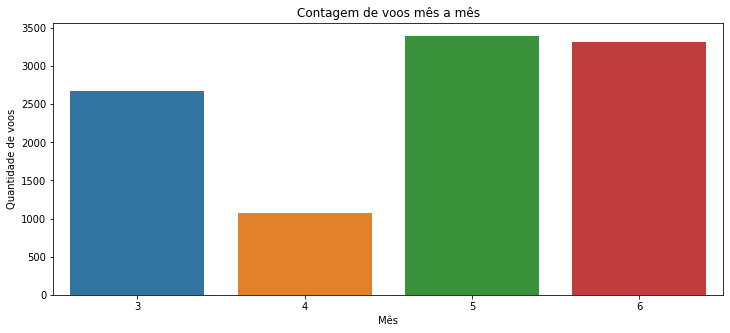

In [32]:
# Plotando a quantidade de viagem por mês
plt.figure(figsize = (12, 5))
plt.title('Contagem de voos mês a mês')
ax=sns.countplot(x = 'Journey_month', data = train_df)
plt.xlabel('Mês')
plt.ylabel('Quantidade de voos');

- Aqui percebe-se que o Mês 5 e 6 possuem maiores quantidades de voos, isso precede investigação, pois pode está atrelado aos preços, campanhas de marketing, ou fatores externos.

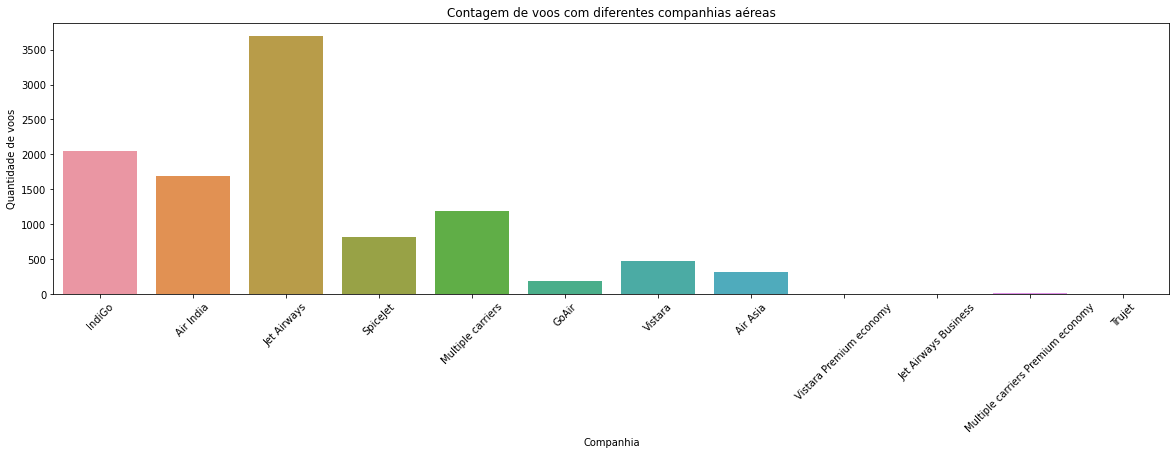

In [33]:
 # Plotando contagens dos voos por companhia
plt.figure(figsize = (20,5))
plt.title('Contagem de voos com diferentes companhias aéreas')
ax=sns.countplot(x = 'Airline', data =train_df)
plt.xlabel('Companhia')
plt.ylabel('Quantidade de voos')
plt.xticks(rotation = 45);

- Aqui se comprova que a JET AIRWAYS, possui mais voos que as demais, talvez por motivos de serviços diferenciados ou publicidades, haja visto no próximo gráfico que os preços praticados assemelha-se com outras companhia

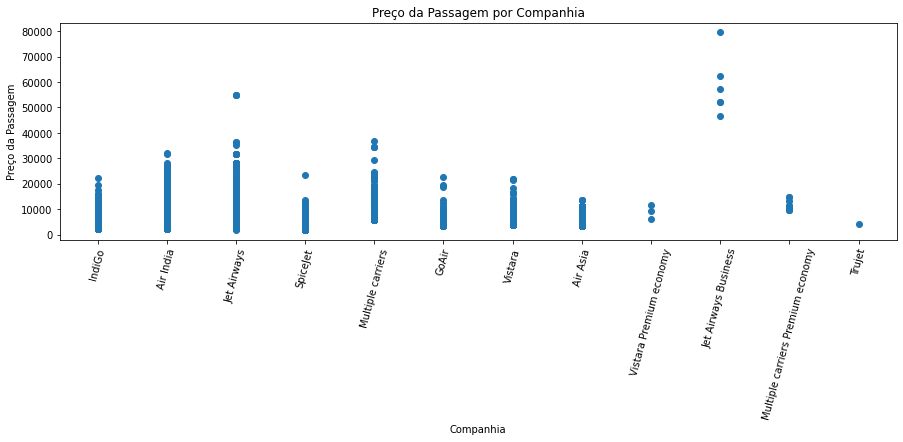

In [34]:
# Plotando o ticket de preços por companhia
plt.figure(figsize = (15,4))
plt.title('Preço da Passagem por Companhia')
plt.scatter(train_df['Airline'], train_df['Price'])
plt.xticks
plt.xlabel('Companhia')
plt.ylabel('Preço da Passagem')
plt.xticks(rotation = 75);

O gráfico dos preços retrata informações relevantes;

1.A empresa JET_AIRWAYS possui um preços equiparado às outras companhias, porém tem maior quantidade de voos.

2.Os maiores preços estão com a empresa JET AIWAYS BUSINEES, talvez se explique por se tratar de voos executivos.

3.Os menores preços não refletem em quantidades de voos

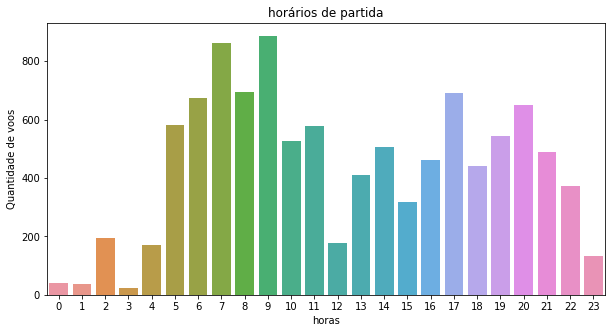

In [35]:
# Plotando os hprários das viagens origens
plt.figure(figsize = (10, 5))
plt.title('horários de partida')
ax=sns.countplot(x = 'Dep_hour', data = train_df)
plt.xlabel('horas')
plt.ylabel('Quantidade de voos');

- Os menores picos de viagens se concentram entre 23hs  e 4hs.

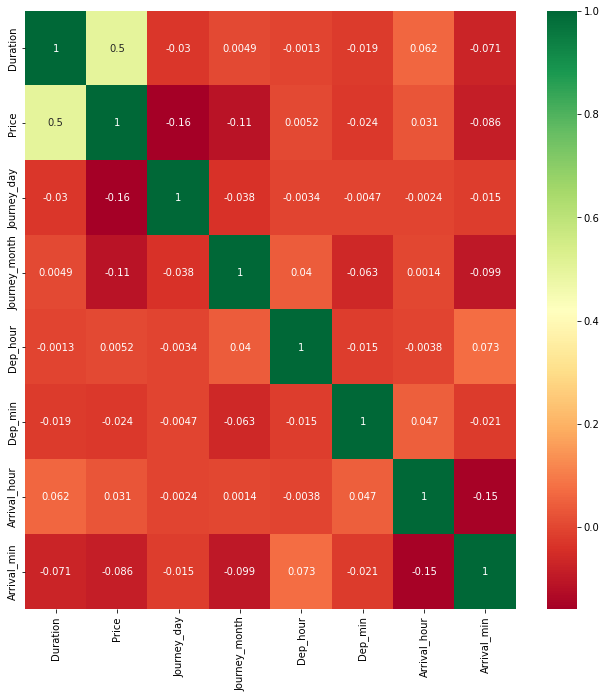

In [36]:
# Plotando a correlação
plt.figure(figsize = (11,11))
sns.heatmap(train_df.corr(), annot = True, cmap = "RdYlGn")
plt.show()

- Aqui observa que o price(preço) tem relação inversa com o Day jorney, ou seja, o preço varia com o dia da viagem.

##- Separando as variáveis categóricas e numéricas

In [37]:
# Definindo X e y de treino
#a = train_df.drop(["Price"], axis=1)
y=train_df["Price"]

In [38]:
# Variáveis categórica e numéricas
train_cat_data = train_df.select_dtypes(exclude=['int64', 'float','int32']) # excluindo as variávies com números, ou seja, ficando apenas com as categóricas
train_nume_data = train_df.select_dtypes(include=['int64', 'float','int32']) # incluindo apenas as numéricas

test_cat_data = test_df.select_dtypes(exclude=['int64', 'float','int32','int32'])
test_nume_data  = test_df.select_dtypes(include=['int64', 'float','int32'])

In [39]:
# observando apenas as numéricas de traino
train_nume_data

,Duration,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,170,3897,24,3,22,20,1,10
1,445,7662,1,5,5,50,13,15
2,1140,13882,9,6,9,25,4,25
3,325,6218,12,5,18,5,23,30
4,285,13302,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...
10678,150,4107,9,4,19,55,22,25
10679,155,4145,27,4,20,45,23,20
10680,180,7229,27,4,8,20,11,20
10681,160,12648,1,3,11,30,14,10


In [40]:
# observando as categóricas do treino
train_cat_data

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info
...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,non-stop,No info
10679,Air India,Kolkata,Banglore,CCU → BLR,non-stop,No info
10680,Jet Airways,Banglore,Delhi,BLR → DEL,non-stop,No info
10681,Vistara,Banglore,New Delhi,BLR → DEL,non-stop,No info


In [41]:
# Label Encode nas categóricas (transformando em números)
le = LabelEncoder()
train_cat_data = train_cat_data.apply(LabelEncoder().fit_transform)
test_cat_data = test_cat_data.apply(LabelEncoder().fit_transform)

In [42]:
# observando a variável
train_cat_data

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,3,0,5,18,4,8
1,1,3,0,84,1,8
2,4,2,1,118,1,8
3,3,3,0,91,0,8
4,3,0,5,29,0,8
...,...,...,...,...,...,...
10678,0,3,0,64,4,8
10679,1,3,0,64,4,8
10680,4,0,2,18,4,8
10681,10,0,5,18,4,8


In [43]:
# concatenando as variáveis numéricas e categ[oricas]
X = pd.concat([train_cat_data, train_nume_data], axis=1)
test_set = pd.concat([test_nume_data, test_cat_data], axis=1)
X.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Duration,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,3,0,5,18,4,8,170,3897,24,3,22,20,1,10
1,1,3,0,84,1,8,445,7662,1,5,5,50,13,15
2,4,2,1,118,1,8,1140,13882,9,6,9,25,4,25
3,3,3,0,91,0,8,325,6218,12,5,18,5,23,30
4,3,0,5,29,0,8,285,13302,1,3,16,50,21,35


In [44]:
#padronizando variavel X de treino
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X)
Xtreino_mod=scaler.fit_transform(X)

Xtreino_mod  


array([[-0.41491593, -1.64687738,  2.40421327, ..., -0.2341234 ,
        -1.8070449 , -0.88836709],
       [-1.26075586,  0.88205718, -0.97201213, ...,  1.36036441,
        -0.05655381, -0.58661071],
       [ 0.00800403,  0.03907899, -0.29676705, ...,  0.03162457,
        -1.36942213,  0.01690205],
       ...,
       [ 0.00800403, -1.64687738,  0.37847803, ..., -0.2341234 ,
        -0.34830233, -0.28485433],
       [ 2.5455238 , -1.64687738,  2.40421327, ...,  0.29737254,
         0.08932044, -0.88836709],
       [-1.26075586,  0.03907899, -0.29676705, ...,  1.62611238,
         0.81869173, -0.58661071]])

In [45]:
# Padronização da variáveis de teste
scaler = StandardScaler().fit(test_set)
X_testmod=scaler.fit_transform(test_set)
X_testmod

array([[ 0.0386528 , -0.83572717,  1.09778298, ...,  0.80362292,
        -0.79124566,  0.48091722],
       [-0.78994238, -0.109863  ,  0.24301819, ...,  0.39741359,
        -0.79124566,  0.48091722],
       [ 1.57604628,  0.97893327,  0.24301819, ...,  0.80362292,
        -0.79124566, -2.14723578],
       ...,
       [-0.48046707, -0.83572717, -1.46651139, ...,  0.80362292,
        -0.79124566,  0.48091722],
       [ 0.55777268, -0.83572717, -1.46651139, ...,  0.80362292,
        -0.79124566,  0.48091722],
       [ 0.44795886,  0.25306909,  1.09778298, ...,  0.80362292,
        -0.79124566,  0.48091722]])

In [46]:
# gerando dataframe de treino padronizado
novo_df_treino = pd.DataFrame(Xtreino_mod,index=train_df.index,columns= train_df.columns)
novo_df_treino

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,-0.414916,-1.646877,2.404213,-1.533452,1.392916,0.497963,-0.918323,-1.109233,1.244442,-1.462080,1.662578,-0.234123,-1.807045,-0.888367
1,-1.260756,0.882057,-0.972012,0.264633,-0.254274,0.497963,-0.369065,-0.295113,-1.471958,0.256507,-1.305841,1.360364,-0.056554,-0.586611
2,0.008004,0.039079,-0.296767,1.190918,-0.254274,0.497963,1.019061,1.049859,-0.527123,1.115800,-0.607390,0.031625,-1.369422,0.016902
3,-0.414916,0.882057,-0.972012,0.455339,-0.803337,0.497963,-0.608741,-0.607355,-0.172810,0.256507,0.964126,-1.031367,1.402189,0.318658
4,-0.414916,-1.646877,2.404213,-1.233771,-0.803337,0.497963,-0.688633,0.924444,-1.471958,-1.462080,0.614900,1.360364,1.110440,0.620415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,-1.683676,0.882057,-0.972012,-0.280241,1.392916,0.497963,-0.958269,-1.063824,-0.527123,-0.602787,1.138739,1.626112,1.256315,0.016902
10679,-1.260756,0.882057,-0.972012,-0.280241,1.392916,0.497963,-0.948283,-1.055607,1.598755,-0.602787,1.313352,1.094616,1.402189,-0.284854
10680,0.008004,-1.646877,0.378478,-1.533452,1.392916,0.497963,-0.898350,-0.388743,1.598755,-0.602787,-0.782003,-0.234123,-0.348302,-0.284854
10681,2.545524,-1.646877,2.404213,-1.533452,1.392916,0.497963,-0.938296,0.783027,-1.471958,-1.462080,-0.258164,0.297373,0.089320,-0.888367


- É preciso gerar um dataframe padronizado para teste

In [47]:
# Gerando dataframe dos dados de treino
X_testmod=pd.DataFrame(X_testmod,index=test_df.index,columns=test_df.columns) # indexando nomes das coluns do antigo dataframe para o novo dataframe
X_testmod

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,0.038653,-0.835727,1.097783,0.772098,0.267435,-1.366298,0.026232,0.008716,0.030594,-0.293844,0.803623,-0.791246,0.480917
1,-0.789942,-0.109863,0.243018,-1.165138,-0.256540,-0.512126,-0.271549,-0.426286,0.873530,-0.976212,0.397414,-0.791246,0.480917
2,1.576046,0.978933,0.243018,1.124323,-0.518527,0.769131,-1.462674,0.008716,0.030594,-0.293844,0.803623,-0.791246,-2.147236
3,0.288230,0.978933,0.243018,-0.812914,-1.304489,1.053855,-1.462674,0.878721,0.030594,-0.293844,0.803623,-0.791246,0.480917
4,-0.929705,1.341865,1.097783,1.828772,1.577372,-1.651022,1.217357,-1.731292,-1.655278,0.388524,-1.412064,1.429868,0.480917
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,1.596012,-0.835727,1.097783,1.300435,0.267435,0.911493,0.026232,-1.296290,0.873530,-0.976212,-0.119580,-0.791246,0.480917
2667,-0.959655,1.704797,-1.466511,0.243761,-0.256540,0.342045,1.812919,-0.426286,0.873530,-0.976212,-0.415005,1.429868,0.480917
2668,-0.480467,-0.835727,-1.466511,1.476548,1.315385,-1.366298,0.026232,0.008716,0.030594,-0.293844,0.803623,-0.791246,0.480917
2669,0.557773,-0.835727,-1.466511,-1.517363,-1.304489,0.769131,-0.569331,-1.296290,0.030594,-0.293844,0.803623,-0.791246,0.480917


In [48]:
 print(X_testmod.shape, novo_df_treino.shape)

(2645, 13) (10462, 14)


In [49]:

X_testmod.drop('Additional_Info', inplace=True, axis=1)


In [50]:
X_testmod.shape

(2645, 12)

## MODELOS PREDITIVOS

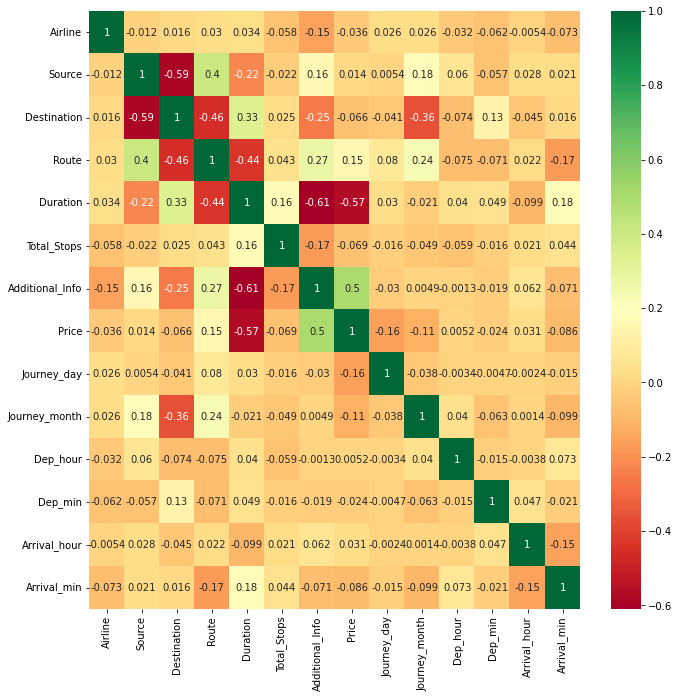

In [51]:
# fazendo a correlação de todas variávies de treino
plt.figure(figsize = (11,11))
sns.heatmap(novo_df_treino.corr(), annot = True, cmap = "RdYlGn")
plt.show()

Aqui irei dropar a variável addtional_info pela sua forte correlação e poucas informações precisas sobre á variável.

In [52]:
# determinando as variáveis dependendente e target
a=novo_df_treino.drop(['Price','Additional_Info'], axis=1)
b=novo_df_treino['Price']


In [53]:
# Validação de folds
validacao = KFold (n_splits=10,  shuffle=True   )

In [54]:
# Separação dos dados de treino e teste para a MP
X_train, X_test, y_train, y_test = train_test_split(a,b, test_size = 0.2)

In [55]:
print("O shape de X_treino é:", X_train.shape)
print("O shape de Y_treino é:", y_train.shape)
print("O shape de de x_teste é:", X_test.shape)
print("O shape de y_teste é:", y_test.shape)

O shape de X_treino é: (8369, 12)
O shape de Y_treino é: (8369,)
O shape de de x_teste é: (2093, 12)
O shape de y_teste é: (2093,)


# KNN

In [56]:
# Rodando o modelo
modelo = KNeighborsRegressor( )
validacao = KFold (n_splits=10,  shuffle=True )      
parametros = { 'n_neighbors' : np.arange(1, 100, 2) }



grid_knn = GridSearchCV( modelo, param_grid = parametros,
                                   scoring = 'neg_mean_squared_error', 
                                   cv = validacao, 
                                   verbose = 1,
                                   n_jobs = -1)

grid_knn.fit(a,b)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             scoring='neg_mean_squared_error', verbose=1)

In [57]:
# buscando melhor score
grid_knn.best_score_

-0.22682144406524207

In [58]:
# Buscando o melhor parâmetros
grid_knn.best_params_

{'n_neighbors': 3}

In [59]:
# Buscando os resultados
grid_knn.cv_results_['mean_test_score']

array([-0.26632666, -0.22682144, -0.23610514, -0.24618788, -0.25991087,
       -0.27247943, -0.28592691, -0.29896631, -0.30733972, -0.31493787,
       -0.32127824, -0.32766147, -0.33393605, -0.33981875, -0.34509627,
       -0.34993825, -0.35590812, -0.35994988, -0.36510418, -0.36916828,
       -0.37336598, -0.3772189 , -0.37989851, -0.38355695, -0.38735467,
       -0.39155353, -0.39508132, -0.39814141, -0.40189691, -0.40488281,
       -0.40729553, -0.41003699, -0.4123694 , -0.41538205, -0.41843069,
       -0.42094357, -0.42322106, -0.42561743, -0.42751296, -0.429863  ,
       -0.43223087, -0.43443293, -0.43683978, -0.43890293, -0.44108804,
       -0.44319857, -0.44510255, -0.44705119, -0.44893964, -0.45074906])

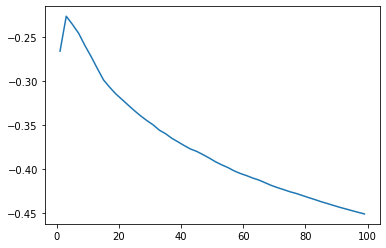

In [60]:
# Verificando os melhores resultados do modelo em gráficos
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 100, 2), grid_knn.cv_results_['mean_test_score']);

O gráfico demonstra que os melhores resultados estão entre 0,21 e qualquer resultado acima é gasto de processamento

# ÁRVORE DE DECISÃO

In [61]:
# Rodando o modelo

modelo = DecisionTreeRegressor( )
        
parametros = { 'max_depth' : np.arange(1, 100, 3), 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 3, 5]
              } 

#score=['neg_mean_absolute_error','neg_mean_squared_error']

grid_arv= GridSearchCV(modelo, param_grid = parametros,
                                   scoring = 'neg_mean_squared_error', 
                                   cv = validacao, 
                                   verbose = 1,
                                   n_jobs = -1)

grid_arv.fit(a,b)

Fitting 10 folds for each of 297 candidates, totalling 2970 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97]),
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [62]:
# Buscando melhor score
print('O melhor score é:', grid_arv.best_score_)

O melhor score é: -0.14633556444689014


In [63]:
# buscando melhor parâmentros
print('O melhor parametro é:')
grid_arv.best_params_


O melhor parametro é:


{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [64]:
# Buscando os resultados
print('Os resultados sao: ')

grid_arv.cv_results_['mean_test_score']

Os resultados sao: 


array([-0.6265249 , -0.6265249 , -0.6265249 , -0.6265249 , -0.6265249 ,
       -0.6265249 , -0.6265249 , -0.6265249 , -0.6265249 , -0.45064268,
       -0.45064268, -0.45064268, -0.45066804, -0.45066804, -0.45066804,
       -0.45160798, -0.45160798, -0.45160798, -0.2435809 , -0.24491022,
       -0.24135313, -0.26011644, -0.26048544, -0.26154216, -0.25368303,
       -0.2536803 , -0.25371725, -0.1771847 , -0.17941839, -0.17759894,
       -0.18424418, -0.18567386, -0.18771289, -0.19015227, -0.1899311 ,
       -0.19039502, -0.15727478, -0.15752451, -0.15986656, -0.16643681,
       -0.16723596, -0.16546635, -0.16935394, -0.16918974, -0.16950949,
       -0.15222673, -0.14925437, -0.14633556, -0.16059215, -0.16029216,
       -0.15932199, -0.16276601, -0.16308045, -0.16298209, -0.16074726,
       -0.15391144, -0.14892566, -0.16231967, -0.16240093, -0.16032649,
       -0.16380471, -0.16345259, -0.16358776, -0.17057156, -0.15205   ,
       -0.14969652, -0.16339479, -0.16323072, -0.16033056, -0.16

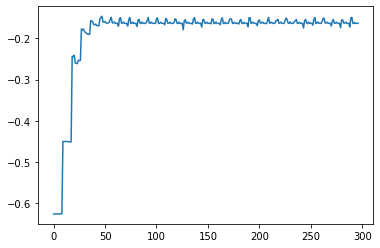

In [65]:
# buscando o resultado do modelo no gráfico
plt.plot( grid_arv.cv_results_['mean_test_score']);

Aqui percebe-se que o modelo se estabiliza em resultado abaixo de 0,2

# RANDOM FOREST

In [66]:
# Rodando o modelo

modelo = RandomForestRegressor( )
        
parametros = { 'max_depth' : np.arange(1, 100,5 ), 
              'n_estimators': [25, 50, 70], 
             
              'bootstrap': [True, False] ,  
              'min_samples_split': [2, 5,3 ]
               } 

#score=['neg_mean_absolute_error','neg_mean_squared_error']

rf_grid = GridSearchCV(modelo, param_grid = parametros,
                                   scoring = 'neg_mean_squared_error', 
                                   cv = validacao, 
                                   verbose = 10,
                                   n_jobs = -1)

rf_grid.fit(a,b)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96]),
                         'min_samples_split': [2, 5, 3],
                         'n_estimators': [25, 50, 70]},
             scoring='neg_mean_squared_error', verbose=10)

In [67]:
# Buscando melhor score
print('O melhor score é:')
rf_grid.best_score_ 

O melhor score é:


-0.09961540235159194

In [68]:
# buscando melhor parâmentros
print('Os melhores parâmetros são: ')
rf_grid.best_params_

Os melhores parâmetros são: 


{'bootstrap': True,
 'max_depth': 16,
 'min_samples_split': 2,
 'n_estimators': 70}

In [69]:
# Buscando os resultados
rf_grid.cv_results_['mean_test_score']

array([-0.62655153, -0.6265483 , -0.62657482, -0.62662501, -0.62654092,
       -0.62654886, -0.62655541, -0.62652132, -0.62656007, -0.25572315,
       -0.25452124, -0.24781052, -0.24865992, -0.25103162, -0.25195543,
       -0.25093861, -0.24844624, -0.25228221, -0.11780443, -0.11829986,
       -0.1189401 , -0.12867028, -0.12500778, -0.12529907, -0.12633532,
       -0.1204801 , -0.12065685, -0.10498135, -0.10311215, -0.0996154 ,
       -0.10886029, -0.10346424, -0.10614941, -0.10018664, -0.10721215,
       -0.10165169, -0.10706904, -0.10120107, -0.10275259, -0.10885229,
       -0.10499142, -0.10477595, -0.10505062, -0.10393585, -0.10447194,
       -0.11098963, -0.10392023, -0.10327242, -0.10992652, -0.10617994,
       -0.10585405, -0.10583732, -0.10307212, -0.1028736 , -0.10375235,
       -0.10593356, -0.10388775, -0.10679973, -0.10648452, -0.10664399,
       -0.10581776, -0.10436478, -0.10639242, -0.1090985 , -0.10308453,
       -0.10680217, -0.11295487, -0.10618825, -0.10594232, -0.10

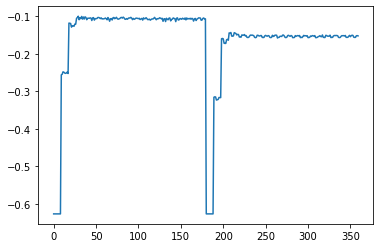

In [70]:
# buscando o resultado do modelo no gráfico
plt.plot( rf_grid.cv_results_['mean_test_score']);

In [71]:
# melhores estimadores
rf_grid.best_estimator_

RandomForestRegressor(max_depth=16, n_estimators=70)

## Predição com o melhor modelo do "grid"

In [72]:

# fazendo a predição do novo modelo
y_preditos_teste=rf_grid.predict(X_test)
y_preditos_teste

array([ 0.31502448,  0.85200249,  1.23199948, ...,  0.86541215,
       -0.10223896, -1.15672449])

In [73]:

gabarito = pd.DataFrame({'Real':y_test,'Previsoes_da_Máquina': y_preditos_teste})
gabarito



,Real,Previsoes_da_Máquina
10582,0.137570,0.315024
3542,0.792541,0.852002
4226,1.229766,1.231999
5290,-0.913109,-0.911654
273,1.999774,2.004963
...,...,...
10240,0.890063,0.791678
3092,1.229766,1.393536
7795,0.865412,0.865412
1977,-0.118451,-0.102239


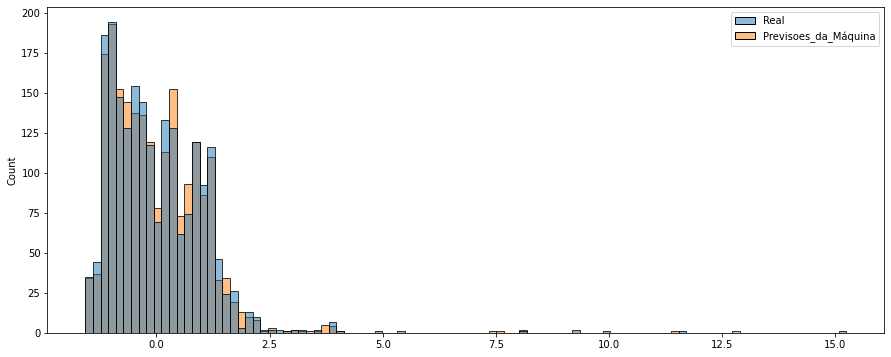

In [74]:
fig, ax = plt.subplots(1,  figsize=(15, 6));
sns.histplot (data=gabarito , bins=100, )

O histograma apresenta uma distrinuição bem concentrada entre as previsões reais com pouco erros na previsão da máquina, isso valida o bom comportamento do modelo.

#### AVALIAÇÃO DE MÉTRICAS NO TREINO

In [75]:
y_preditos_treino=rf_grid.predict(X_train)

In [76]:
# Printando as Métricas de Avaliação da MP com dados de treino
print("Resultado do treino do grid do randomforest:")
print("Root Mean squared Error RMSE: ", sqrt(mse(y_train, y_preditos_treino)))
print("Mean Absolute % Error: ", ( mean_absolute_error  (y_train, y_preditos_treino)))
print("R-Squared: ", r2_score(y_train, y_preditos_treino))

Resultado do treino do grid do randomforest:
Root Mean squared Error RMSE:  0.13801459554042253
Mean Absolute % Error:  0.06582774520227777
R-Squared:  0.9798748046028224


#### AVALIAÇÃO DE MÉTRICAS NO TESTE

In [77]:
# Printando as Métricas de Avaliação da MP com dados de treino
print("Resultado do teste do grid do randomforest:")
print("Root Mean squared Error RMSE: ", sqrt(mse(y_test, y_preditos_teste)))
print("Mean Absolute % Error: ", ( mean_absolute_error  (y_test, y_preditos_teste)))
print("R-Squared: ", r2_score(y_test, y_preditos_teste))

Resultado do teste do grid do randomforest:
Root Mean squared Error RMSE:  0.1681581147142089
Mean Absolute % Error:  0.06536547713264586
R-Squared:  0.976707320649484


#### SALVANDO O MODELO

In [80]:
import joblib
model_name = "modelo_prev_aerea.pkl"
joblib.dump(value=rf_grid , filename=model_name)

['modelo_prev_aerea.pkl']

In [83]:
# lendo modelo
model_name=joblib.load("modelo_prev_aerea.pkl")

In [86]:
# predizendo em novos dados
model_name.predict(X_test)

array([ 0.30240774,  0.83807238,  1.23257228, ...,  0.86541215,
       -0.10661834, -1.16373569])

#### CONSIDERAÇÕES FINAIS

Através das análises do dados verificou-se que:

- Até 50% dos preços das passagens estão em torno de 8372 moeda local da india,sendo que exitem preços de 79.512 que reflete uam caracterísitica de serviços ou produtos diferenciado (voos executivos por exemplos).


- Em relação preços e localização do inicio das viagens, percebe-se que os valores se emcontram nos custos de 10000 e 20000. Porém KOLKATA e DELHI apresentam uma leve supremacia em relação às outras. além disso, esse gráfico apresenta os cincos principais voos de origens

- Quanto ao preço por destino se destaca COCHIN  e  BANGLORE com os melhores preços destinos. è importante ressaltar que os voos de destino se diferenciam em preços e localização aos de origens.

- O maior número de viagens em relação ao preço, está com duração de 10hs e valor de 14714. porém existem preços menores com a mesma duraçao de viagens, levando a considerar que a duração do tempo de voo, não determina por si só as tarifas.Isso significa que é preciso conversar com a área de negócio sobre formação de preços.

- Quanto á modelagemo modelo escolhido foi baseado nos testes com métricas de avaliação que precisou um erro médio absoluto de 6%, com acertividade de 94%,onde as variáveis explicativas contibuiram com o modelo em em 97%, porém é preciso que o modelo seja checado de forma a garantir à eficiencia da proposta